# Import Dependencies

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv(r"C:\Users\Dickson\SEMANTIC SEARCH\Data\processed\arxiv_clean.csv")

In [3]:
df.head()

,title,summary
0,Dual Recurrent Attention Units for Visual Ques...,We propose an architecture for VQA which utili...
1,Sequential Short-Text Classification with Recu...,Recent approaches based on artificial neural n...
2,Multiresolution Recurrent Neural Networks: An ...,We introduce the multiresolution recurrent neu...
3,Learning what to share between loosely related...,Multi-task learning is motivated by the observ...
4,A Deep Reinforcement Learning Chatbot,We present MILABOT: a deep reinforcement learn...


In [4]:
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
title      0
summary    0
dtype: int64


In [5]:
# Create combined field
df["text"] = df["title"].fillna("") + " " + df["summary"].fillna("")

In [6]:
df.head()

,title,summary,text
0,Dual Recurrent Attention Units for Visual Ques...,We propose an architecture for VQA which utili...,Dual Recurrent Attention Units for Visual Ques...
1,Sequential Short-Text Classification with Recu...,Recent approaches based on artificial neural n...,Sequential Short-Text Classification with Recu...
2,Multiresolution Recurrent Neural Networks: An ...,We introduce the multiresolution recurrent neu...,Multiresolution Recurrent Neural Networks: An ...
3,Learning what to share between loosely related...,Multi-task learning is motivated by the observ...,Learning what to share between loosely related...
4,A Deep Reinforcement Learning Chatbot,We present MILABOT: a deep reinforcement learn...,A Deep Reinforcement Learning Chatbot We prese...


In [7]:
# Length features
df["title_len"] = df["title"].apply(lambda x: len(x.split()))
df["summary_len"] = df["summary"].apply(lambda x: len(x.split()))
df["text_len"] = df["text"].apply(lambda x: len(x.split()))

In [8]:
# Quick stats
print("\n--- Length Statistics ---")
print(df[["title_len", "summary_len", "text_len"]].describe())



--- Length Statistics ---
          title_len   summary_len      text_len
count  41000.000000  41000.000000  41000.000000
mean       8.718951    150.529244    159.248195
std        3.214763     52.986181     53.481417
min        1.000000      3.000000      8.000000
25%        7.000000    113.000000    121.000000
50%        8.000000    147.000000    156.000000
75%       11.000000    184.000000    193.000000
max       33.000000    558.000000    565.000000


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

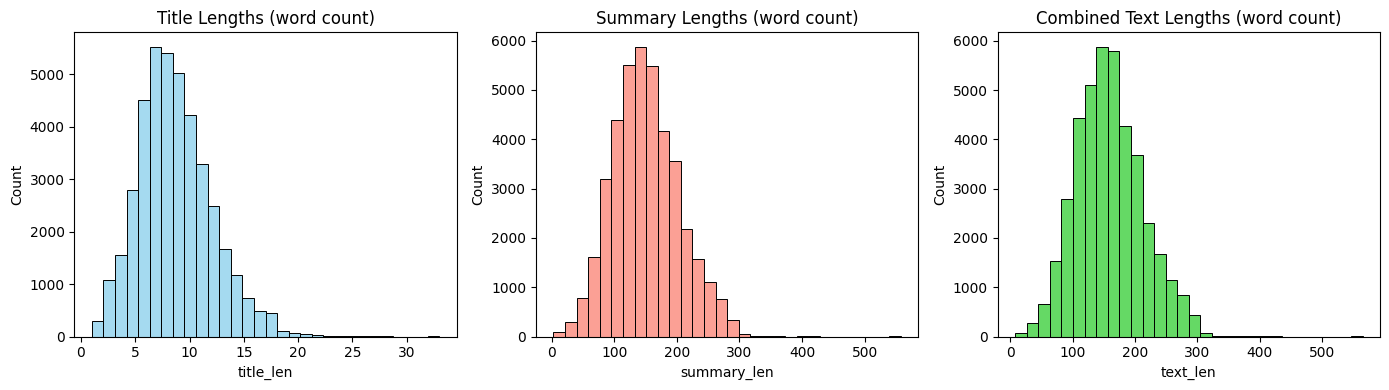

In [10]:
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
sns.histplot(df["title_len"], bins=30, color="skyblue")
plt.title("Title Lengths (word count)")

plt.subplot(1,3,2)
sns.histplot(df["summary_len"], bins=30, color="salmon")
plt.title("Summary Lengths (word count)")

plt.subplot(1,3,3)
sns.histplot(df["text_len"], bins=30, color="limegreen")
plt.title("Combined Text Lengths (word count)")

plt.tight_layout()
plt.show()

In [11]:
from wordcloud import WordCloud

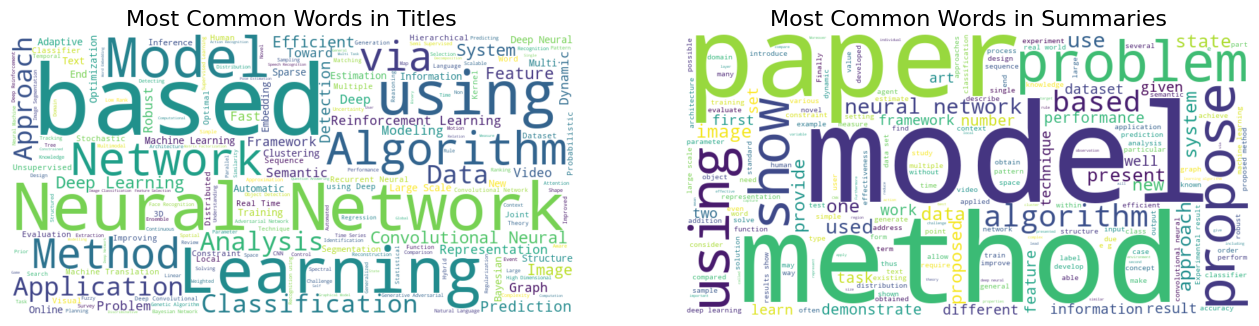

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))

# Title word cloud
title_text = " ".join(df["title"].astype(str).values)
wordcloud_title = WordCloud(width=800, height=400, background_color="white").generate(title_text)
axes[0].imshow(wordcloud_title, interpolation="bilinear")
axes[0].set_title("Most Common Words in Titles", fontsize=16)
axes[0].axis("off")

# Summary word cloud
summary_text = " ".join(df["summary"].astype(str).values)
wordcloud_summary = WordCloud(width=800, height=400, background_color="white").generate(summary_text)
axes[1].imshow(wordcloud_summary, interpolation="bilinear")
axes[1].set_title("Most Common Words in Summaries", fontsize=16)
axes[1].axis("off")

plt.show()

# Text Embedding

In [13]:
from sentence_transformers import SentenceTransformer

c:\Users\Dickson\SEMANTIC SEARCH\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
model = SentenceTransformer('all-MiniLM-L6-v2')
print("Sentence-Transformers works!")


Sentence-Transformers works!


In [15]:
embeddings = model.encode(
    df["text"].tolist(),
    batch_size=32,      
    show_progress_bar=True,
    convert_to_numpy=True
)

Batches: 100%|██████████| 1282/1282 [56:27<00:00,  2.64s/it] 


In [16]:
np.save(r"C:\Users\Dickson\SEMANTIC SEARCH\Data\processed\arxiv_embeddings.npy", embeddings)


In [17]:
print("Embeddings shape:", embeddings.shape)
print("Example embedding vector (first paper):", embeddings[0][:10])  # preview first 10 dims


Embeddings shape: (41000, 384)
Example embedding vector (first paper): [ 0.01564444 -0.07435437 -0.00280869  0.02971766  0.03936672  0.06410635
 -0.01386171  0.04750125  0.02277074 -0.03032245]


In [18]:
import faiss

In [19]:
# Load embeddings
embeddings = np.load(r"C:\Users\Dickson\SEMANTIC SEARCH\Data\processed\arxiv_embeddings.npy")


In [20]:
# Normalize embeddings for cosine similarity
embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

# Create FAISS index (cosine similarity = inner product on normalized vectors)
dimension = embeddings.shape[1]  # 384
index = faiss.IndexFlatIP(dimension)  # IP = Inner Product
index.add(embeddings)

print("FAISS index built with", index.ntotal, "vectors")

FAISS index built with 41000 vectors


# Querying the index

In [21]:
model = SentenceTransformer("all-MiniLM-L6-v2")

# Example user query
query = "reinforcement learning for dialogue systems"

# Encode query and normalize
query_emb = model.encode([query])
query_emb = query_emb / np.linalg.norm(query_emb, axis=1, keepdims=True)

# Search top 5 results
k = 5
distances, indices = index.search(query_emb, k)

In [22]:
df = pd.read_csv(r"C:\Users\Dickson\SEMANTIC SEARCH\Data\processed\arxiv_clean.csv")

print("\nTop search results:")
for idx, dist in zip(indices[0], distances[0]):
    print(f"Score: {dist:.4f} | Title: {df.iloc[idx]['title']}")



Top search results:
Score: 0.7361 | Title: Optimizing Dialogue Management with Reinforcement Learning: Experiments
  with the NJFun System
Score: 0.6999 | Title: SimpleDS: A Simple Deep Reinforcement Learning Dialogue System
Score: 0.6985 | Title: A Benchmarking Environment for Reinforcement Learning Based Task
  Oriented Dialogue Management
Score: 0.6769 | Title: An Application of Reinforcement Learning to Dialogue Strategy Selection
  in a Spoken Dialogue System for Email
Score: 0.6730 | Title: Feudal Reinforcement Learning for Dialogue Management in Large Domains


Now that you’ve proven it works, the next step is making the workflow smooth. I’d suggest wrapping the search into a simple function:

In [23]:
def search_papers(query, model, index, df, top_k=5):
    # Encode and normalize query
    query_emb = model.encode([query])
    query_emb = query_emb / np.linalg.norm(query_emb, axis=1, keepdims=True)
    
    # Search in FAISS
    distances, indices = index.search(query_emb, top_k)
    
    # Collect results
    results = []
    for idx, dist in zip(indices[0], distances[0]):
        results.append({
            "score": round(float(dist), 4),
            "title": df.iloc[idx]["title"],
            "summary": df.iloc[idx]["summary"]
        })
    return results

# Example usage
query = "deep learning for computer vision"
results = search_papers(query, model, index, df, top_k=5)

for r in results:
    print(f"\nScore: {r['score']} | {r['title']}\nSummary: {r['summary'][:200]}...")



Score: 0.6664 | A Taxonomy of Deep Convolutional Neural Nets for Computer Vision
Summary: Traditional architectures for solving computer vision problems and the degree
of success they enjoyed have been heavily reliant on hand-crafted features.
However, of late, deep learning techniques hav...

Score: 0.6255 | ChainerCV: a Library for Deep Learning in Computer Vision
Summary: Despite significant progress of deep learning in the field of computer
vision, there has not been a software library that covers these methods in a
unifying manner. We introduce ChainerCV, a software ...

Score: 0.6061 | Deep Image: Scaling up Image Recognition
Summary: We present a state-of-the-art image recognition system, Deep Image, developed
using end-to-end deep learning. The key components are a custom-built
supercomputer dedicated to deep learning, a highly o...

Score: 0.5917 | Very Deep Convolutional Networks for Large-Scale Image Recognition
Summary: In this work we investigate the effect of the convolu

# Evaluation 

In [24]:
test_queries = {
    "reinforcement learning": ["reinforcement learning", "dialogue management", "Q-learning"],
    "computer vision": ["image recognition", "convolutional networks", "object detection"],
    "natural language processing": ["language models", "machine translation", "BERT"]
}


In [25]:
def evaluate_queries(test_queries, model, index, df, top_k=10):
    results = {}
    
    for topic, keywords in test_queries.items():
        # Encode query
        query_emb = model.encode([topic])
        query_emb = query_emb / np.linalg.norm(query_emb, axis=1, keepdims=True)
        
        # Search
        distances, indices = index.search(query_emb, top_k)
        retrieved_titles = df.iloc[indices[0]]["title"].str.lower().tolist()
        
        # Ground truth: check if any keyword appears in retrieved docs
        relevant = 0
        for title in retrieved_titles:
            if any(kw in title for kw in keywords):
                relevant += 1
        
        precision = relevant / top_k
        results[topic] = {"precision@10": round(precision, 3)}
    
    return results

# Run evaluation
eval_results = evaluate_queries(test_queries, model, index, df, top_k=10)
print(eval_results)


{'reinforcement learning': {'precision@10': 0.8}, 'computer vision': {'precision@10': 0.0}, 'natural language processing': {'precision@10': 0.0}}


In [37]:
import numpy as np

def dcg_at_k(relevances, k):
    """Compute DCG at k given binary relevance labels."""
    relevances = np.asfarray(relevances)[:k]
    if relevances.size:
        return np.sum((2**relevances - 1) / np.log2(np.arange(2, relevances.size + 2)))
    return 0.0

def ndcg_at_k(relevances, k):
    """Compute nDCG at k."""
    dcg = dcg_at_k(relevances, k)
    ideal_dcg = dcg_at_k(sorted(relevances, reverse=True), k)
    return dcg / ideal_dcg if ideal_dcg > 0 else 0.0


def semantic_evaluate(queries, model, index, df, top_k=10):
    results = {}

    # Ensure df has a "text" column
    if "text" not in df.columns:
        if "title" in df.columns and "summary" in df.columns:
            df["text"] = df["title"] + " " + df["summary"]
        elif "title" in df.columns:
            df["text"] = df["title"]
        elif "summary" in df.columns:
            df["text"] = df["summary"]
        else:
            raise ValueError("No suitable text columns found (need 'title' or 'summary').")

    for query in queries:
        query_embedding = model.encode(query, convert_to_tensor=True)
        distances, indices = index.search(query_embedding.cpu().numpy(), top_k)

        retrieved_texts = df.iloc[indices[0]]["text"].tolist()
        retrieved_titles = df.iloc[indices[0]]["title"].tolist() if "title" in df.columns else retrieved_texts
        retrieved_scores = 1 - distances[0]  # similarity approx

        # Binary relevance: check if query appears in retrieved text
        relevances = [1 if query.lower() in text.lower() else 0 for text in retrieved_texts]

        precision_at_k = sum(relevances) / top_k
        ndcg = ndcg_at_k(relevances, top_k)

        results[query] = {
            f"precision@{top_k}": precision_at_k,
            f"nDCG@{top_k}": ndcg,
            "top_titles": retrieved_titles
        }

        # Print results for inspection
        print(f"\nQuery: {query}")
        print(f"Precision@{top_k}: {precision_at_k:.2f}")
        print(f"nDCG@{top_k}: {ndcg:.2f}")
        print("Top retrieved titles:")
        for rank, (title, score, rel) in enumerate(zip(retrieved_titles, retrieved_scores, relevances), 1):
            print(f"{rank}. {title} (score={score:.4f}, rel={rel})")

    return results


In [39]:
def semantic_evaluate(queries, model, index, df, top_k=10):
    results = {}
    for query in queries:
        query_embedding = model.encode(query, convert_to_tensor=True)
        query_embedding = query_embedding.cpu().numpy().reshape(1, -1)  # <-- FIX

        distances, indices = index.search(query_embedding, top_k)

        retrieved_texts = df.iloc[indices[0]]["text"].tolist()
        retrieved_titles = df.iloc[indices[0]]["title"].tolist() if "title" in df.columns else retrieved_texts

        relevant = [q for q in retrieved_texts if query.lower() in q.lower()]
        precision_at_k = len(relevant) / top_k

        results[query] = {
            "precision@10": round(precision_at_k, 2),
            "top_titles": retrieved_titles
        }
    return results


In [40]:
semantic_eval_results = semantic_evaluate(test_queries, model, index, df, top_k=10)
import pprint
pprint.pprint(semantic_eval_results)


{'computer vision': {'precision@10': 0.7,
                     'top_titles': ['A Novice Guide towards Human Motion '
                                    'Analysis and Understanding',
                                    'Second Croatian Computer Vision Workshop '
                                    '(CCVW 2013)',
                                    'The Cyborg Astrobiologist: First Field '
                                    'Experience',
                                    'Field geology with a wearable computer: '
                                    '1st results of the Cyborg\n'
                                    '  Astrobiologist System',
                                    'Object Recognition System Design in '
                                    'Computer Vision: a Universal\n'
                                    '  Approach',
                                    'Proceedings of The 38th Annual Workshop '
                                    'of the Austrian Association for\n'
     

In [41]:
import pandas as pd

# Convert results dict → DataFrame
def results_to_df(results):
    rows = []
    for query, metrics in results.items():
        rows.append({
            "query": query,
            "precision@10": metrics["precision@10"],
            "top_titles": metrics["top_titles"]
        })
    return pd.DataFrame(rows)

# Build DataFrame
results_df = results_to_df(semantic_eval_results)

# Display neatly
pd.set_option("max_colwidth", 120)  # so long titles don't get truncated
display(results_df)


,query,precision@10,top_titles
0,reinforcement learning,0.9,"[Reinforcement Learning: A Survey, Gradient-based Reinforcement Planning in Policy-Search Methods, Market-Based Rein..."
1,computer vision,0.7,"[A Novice Guide towards Human Motion Analysis and Understanding, Second Croatian Computer Vision Workshop (CCVW 2013..."
2,natural language processing,0.4,"[Natural Language Processing - A Survey, Natural Language Processing: State of The Art, Current Trends and\n Challe..."


# Visualize performance

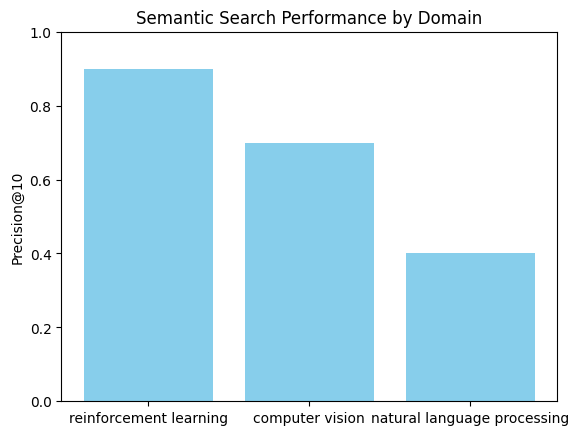

In [42]:
import matplotlib.pyplot as plt

plt.bar(results_df["query"], results_df["precision@10"], color="skyblue")
plt.ylabel("Precision@10")
plt.title("Semantic Search Performance by Domain")
plt.ylim(0, 1)
plt.show()


In [43]:
results_df.to_csv("semantic_search_eval.csv", index=False)

# Fine Tuning

In [46]:
from sentence_transformers import InputExample

train_examples = [
    InputExample(texts=["reinforcement learning", "Reinforcement Learning: A Survey"], label=1.0),
    InputExample(texts=["computer vision", "Reinforcement Learning: A Survey"], label=0.0),
    InputExample(texts=["computer vision", "A Novice Guide towards Human Motion Analysis and Understanding"], label=1.0),
    InputExample(texts=["natural language processing", "Natural Language Processing: A Survey"], label=1.0),
    InputExample(texts=["reinforcement learning", "Natural Language Processing: A Survey"], label=0.0),
]


In [47]:
from sentence_transformers import SentenceTransformer, losses
from torch.utils.data import DataLoader

model = SentenceTransformer("all-MiniLM-L6-v2")


In [48]:
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model)


In [49]:
from sentence_transformers import InputExample, losses
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformerTrainer, SentenceTransformerTrainingArguments


In [51]:
model_save_path = "output/fine_tuned_papers_light"
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=3,
    warmup_steps=10,
    output_path=model_save_path
)

c:\Users\Dickson\SEMANTIC SEARCH\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


In [52]:
base_model = SentenceTransformer("all-MiniLM-L6-v2")

# Your fine-tuned model
fine_tuned_model = SentenceTransformer("output/fine_tuned_papers_light")

In [53]:
queries = [
    "reinforcement learning for dialogue systems",
    "computer vision object recognition",
    "natural language processing chatbot",
]


In [55]:
papers = pd.read_csv(r"C:\Users\Dickson\SEMANTIC SEARCH\Data\processed\arxiv_clean.csv")


In [56]:
def search(model, query, top_k=5):
    query_emb = model.encode([query], convert_to_tensor=True)
    scores, idx = index.search(query_emb.cpu().numpy(), top_k)
    return [(scores[0][i], papers.iloc[idx[0][i]]['title']) for i in range(top_k)]

for q in queries:
    print(f"\n🔎 Query: {q}")
    
    print("\nBase model results:")
    for score, title in search(base_model, q):
        print(f"  {score:.4f} | {title}")
    
    print("\nFine-tuned model results:")
    for score, title in search(fine_tuned_model, q):
        print(f"  {score:.4f} | {title}")



🔎 Query: reinforcement learning for dialogue systems

Base model results:
  0.7361 | Optimizing Dialogue Management with Reinforcement Learning: Experiments
  with the NJFun System
  0.6999 | SimpleDS: A Simple Deep Reinforcement Learning Dialogue System
  0.6985 | A Benchmarking Environment for Reinforcement Learning Based Task
  Oriented Dialogue Management
  0.6769 | An Application of Reinforcement Learning to Dialogue Strategy Selection
  in a Spoken Dialogue System for Email
  0.6730 | Feudal Reinforcement Learning for Dialogue Management in Large Domains

Fine-tuned model results:
  0.7400 | Optimizing Dialogue Management with Reinforcement Learning: Experiments
  with the NJFun System
  0.7036 | SimpleDS: A Simple Deep Reinforcement Learning Dialogue System
  0.7019 | A Benchmarking Environment for Reinforcement Learning Based Task
  Oriented Dialogue Management
  0.6806 | An Application of Reinforcement Learning to Dialogue Strategy Selection
  in a Spoken Dialogue System for 